# Fourier Transform

> NOTE: This notebooks takes the notes from official documentation and tutorial of [OpenCV](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html#fourier-transform).

Fourier Transform (FT) is used to understand the frequency characteristics of various filters and images. For digital images specifically, 2D Discrete Fourier Transform (DFT) is used. The DFT is computed using an algorithm called Fast Fourier Transform (FFT).

For a sinusoidal signal denoted by $x(t) = A \sin{(2{\pi}ft)}$ $f$ is the frequency of the signal, and when the frequency domain transformation is taken for this signal, there should be a spike at $f$. An image is a discrete signal, which can also be transformed to frequency domain, but it would have values in the range of $[-{\pi}, {\pi}]$, $[0, 2{\pi}]$, or $[0, N]$ for $N$ points DFT. An image is also a 2D signal ranging in two directions. A DFT can be taken in both direction, and they together gives the frequency domain representation of the image.

For an analog sinusoidal signal if the amplitude of the signal varies too fast in short time (same as saying more oscillating cycles in short time), then it is high frequency signal. If it does not vary that much, then it it is a low frequency signal. A similar thought process works for images. In an image at the edge points, corners, and stripes the pixel intensity (compared to the signal amplitude) vary the most. In case of salt-n-pepper noise we have also seen similar patterns i.e., random spikes in pixel intensities. Hence edges, corners, stripes, and noises are some of the high frequency contents in an image. In most cases an image has both high and low frequency contents.



In this notebook we'd practice these concepts with some image examples. We would use both NumPy and OpenCV utilities. The NumPy package [numpy.fft](https://numpy.org/doc/stable/reference/routines.fft.html) implementing the FT utilities. Following are some of the useful functions for using the FT with NumPY.

* `fft.fft2` - It provides frequency transform which will be a complex array. Its first argument is the **grayscale** input image. Second argument is optional, which decides the size of output array. If it is greater than size of input image, input image is padded with zeros before calculation of FFT. If it is less than input image, input image will be cropped. If no arguments passed, Output array size will be same as input.
    > There exists a concept called DC component of a signal, which is relevant in this discussion. The DC component of a signal is the average value / amplitude of a signal over a period of time. Translating the same to our context, it is the average pixel intensity. It is also called the `zero frequency component`, because FT decomposes a signal into sine and cosine components. With respect to the cosine component if we consider the cosine component $\cos{(2{\pi}ft)}$ then for $f = 0$ we'd get $\cos{(2{\pi} * 0 * t)} = 1$. Signal offset is thought in this way. Since this represents the zero frequency it is by default goes to the very left of the frequency domain representation. Similar thing happens for an image. Since input image is 2D spatial domain signal, we make frequency domain transform for both x and y direction. Normally in digital representation of an image (x = 0, y = 0) point is on the top left corner. As a result the zero frequency component representing the average change in intensity goes to the top left corner of the resulting image. In order to shift the zero frequency component to middle of the resulting image we have to shuft it by $\frac{N}2$ in both x and y direction for a square input image of shape $(N, N)$. But for a rectangular image it is problematic. Hence we need an easier option, which we get in form of *fftshift*.
* `fft.fftshift` -  It conveniently shifts the zero frequency component to the middle, as we would see shortly.
    > Once we have found the frequency domain representation, we might want to do some filtering like high pass and then we need to reconstruct the image from frequency domain back to spatial domain. First step of that is to shift the zero frequency component back to its original position, where *ifftshift* comes into play.
* `fft.ifftshift`- It shifts the zero frequency components back to top left corner.
* `fft.ifft2` - It transforms the image from frequency domain back to spatial domain.

Similarly, [OpenCV](https://docs.opencv.org/4.5.5/modules.html) offers several functionalities for working with Discrete Fourier Transform. Following are some of the utilities, which are used in this exercises.
* [cv2.dft](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gadd6cf9baf2b8b704a11b5f04aaf4f39d) - It performs forward or inverse discrete fourier transform.
* [cv2.idft](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gaa708aa2d2e57a508f968eb0f69aa5ff1) 
* [cv2.magnitude](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga6d3b097586bca4409873d64a90fe64c3)

In [144]:
from typing import Tuple
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

We start with using two basic signals.

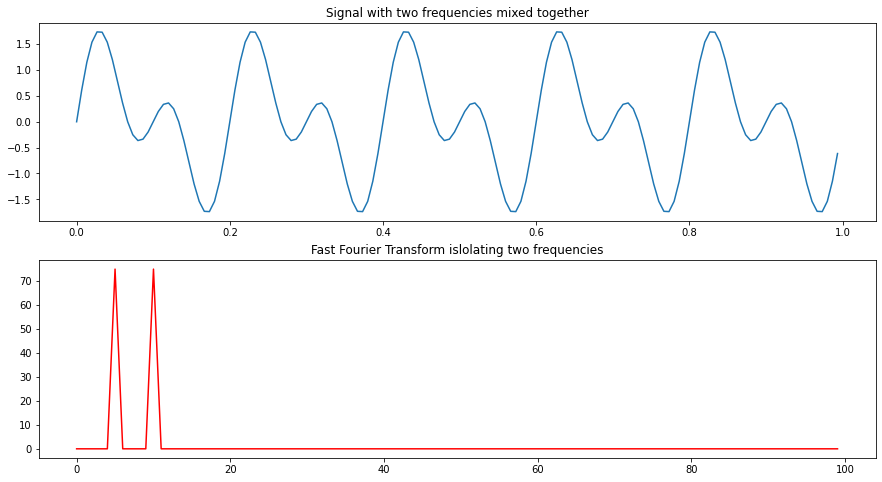

In [145]:
sampling_frequency: float = 150.0
sampling_interval: float = 1.0 / sampling_frequency
time_intervals: np.ndarray = np.arange(0, 1, sampling_interval)

freq1: int = 5
freq2: int = 10

signal: np.ndarray = np.sin(2*np.pi*freq1*time_intervals) + np.sin(2*np.pi*freq2*time_intervals)
sig_ft: np.ndarray = np.fft.fft(signal)

fig, (axs1, axs2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs1.plot(time_intervals, signal)
axs1.set_title('Signal with two frequencies mixed together')
axs2.plot(np.arange(0, 100, 1), np.abs(sig_ft)[:100], 'r')
axs2.set_title('Fast Fourier Transform islolating two frequencies');

First plot shows a signal, where we have mixed two frequencies, 5 Hz and 10 Hz without any phase shift. Then we have taken the FT using the `np.fft` module. We have visualized first 100 components of the FT in the second plot, which clearly isolates the two frequencies, which we have used to create the above signal. In this notebook we apply a similar method to images as spatial signals. We are going to explore some examples of edge detection and noise reduction in images using FT. In the process we'd learn a bit about the filters.

## Filters

Filters in this context, are similar to the masks, which we used in the exercises of the color thresholds. They are of the same size with input images. We superimpose them to the original image to extract the features and attributes of our interest. We have mentioned above the utility of the `np.fft.fftshift`, which shifts the zero and low frequency components of the image towards the center. We are going to see shortly, that this is extremely useful for creating the filters. When the low frequency regions are shifted towards the center of the image, then we can select specific areas of the image and manipulate e.g., assigning zeros or ones to some areas to isolate the high and low frequencies. In this notebook we would try to make use of the following kinds of filters.

* Low-Pass Filter (Only allow low frequency components)
* High-Pass Filter (Only allow high frequency components)
* Band-Pass Filter (Combines the low-pass and high-pass by not throwing away either of the low and high frequencies completely)

In [146]:
# Specify image directory
image_dir: Path = Path().absolute().joinpath('images')

Shape of the image: (1024, 768)


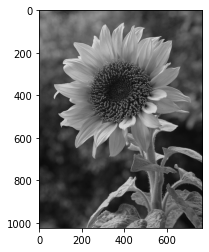

In [147]:
# Import image in grayscale
image: np.ndarray = cv2.imread(image_dir.joinpath('sunflower.jpg').__str__(), cv2.IMREAD_GRAYSCALE)
print(f'Shape of the image: {image.shape}')
plt.imshow(image, cmap='gray');

Shape of the frequency domain transform: (1024, 768, 2)


Text(0.5, 1.0, 'Magnitude Spectrum')

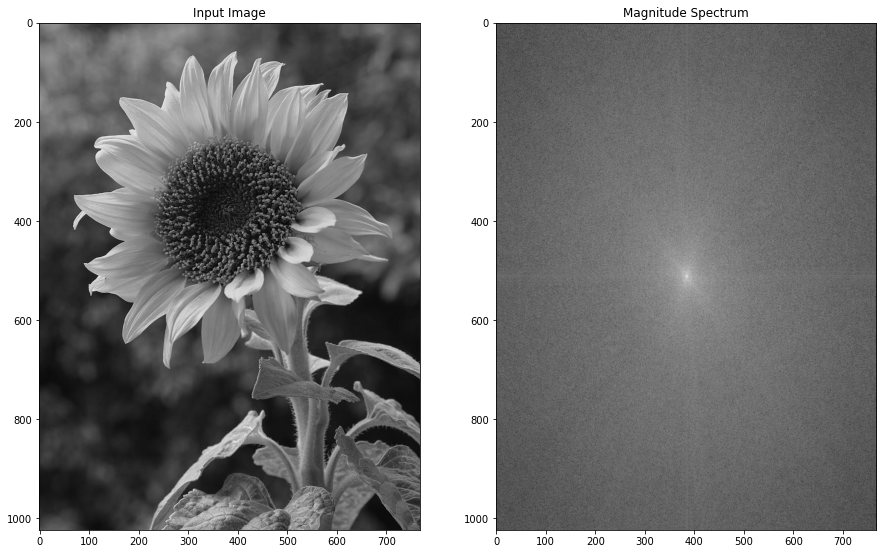

In [151]:
# Convert the image into frequency domain and create magnitude spectrum
f: np.ndarray = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
print(f'Shape of the frequency domain transform: {f.shape}')
# Shift the zero frequency component to the center
fshift: np.ndarray = np.fft.fftshift(f)
magnitude_spectrum: np.ndarray = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))
# Plot the input image and magnitude spectrum side by side
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax1.imshow(image, cmap='gray')
ax1.set_title('Input Image')
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.set_title('Magnitude Spectrum')

There are few key points to notice in the above plots. We have used `fftshift` in order to shift the zero frequency components to the middle, and we see more white regions towards the middle as well. White regions denote amplitude or pixel intensity in this case. We have to keep in mind, that the magnitude spectrum is the frequency domain representation. That means the magnitude spectrum shows us the different pixel intensities, which make our image. In this case magnitude spectrum is showing, that more pixels with high amplitude or intensity belongs to the zero frequency or lower frequency components. In simpler terms it means, that most of the regions in our input image has lower frequency i.e., lesser abrupt change in pixel intensities, resulting in lesser chance to find an edge. That appears to be true, when we look at the original image.

### High-Pass Filter

We are going to create a circular high-pass filter from the frequency domain representation of the image. We have already shifted the zero and low frequencies towards the center (zero frequency is at the absolute center). We are going to create a circular mask of zeros i.e., we'd try to block the very low frequencies. In the following examples we used the [np.ogrid](https://numpy.org/doc/stable/reference/generated/numpy.ogrid.html) function to create an open n-dimensional mesh-grid. In our case this is a mesh-grid, which is not formed yet. It returns the x-dimension indices and y-dimension indices separately. For instance since we have 240 rows and 300 columns, we'd get two separate indices arrays of shape (240, 1) as x-dimensional indices and (1, 300) as y-dimensional indices.

In [149]:
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2
mask: np.ndarray = np.ones((rows, cols, 2), np.uint8)
print(mask.shape)
radius: int = 80  # Circular mask radius
center: Tuple[int, int] = (crow, ccol)
print(center )
x, y = np.ogrid[:rows, :cols]
mask_area: np.ndarray = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2
mask[mask_area] = 0
temp: np.ndarray = fshift * mask

(1024, 768, 2)
(512, 384)


Here's what we did with the above statements.

* Firstly, we have to keep in mind, that `fshift` is the image in frequency domain, where we have shifted the zero and lower frequency components towards the middle. The exact middle has the zero frequency component, which is representative of those regions of the image, where no change in happening in pixel intensity.
* Using integer division we got the index of the middle pixel in the frequency domain image (technically we should not call it an image, because it has complex number components in it). For convenience we can refer to the magnitude spectrum, keeping in mind that we are still referring to the frequency domain representation of the image.
* Using slicing we selected a (60, 60) shaped portion of the frequency domain representation, where all low frequencies are and we assigned 0 to them. This left only relatively higher frequency components.

This is the essence of high-pass filtering in the frequency domain. Now, we'd do the inverse Fourier Transform to take the image representation back from frequency domain to the spatial domain.

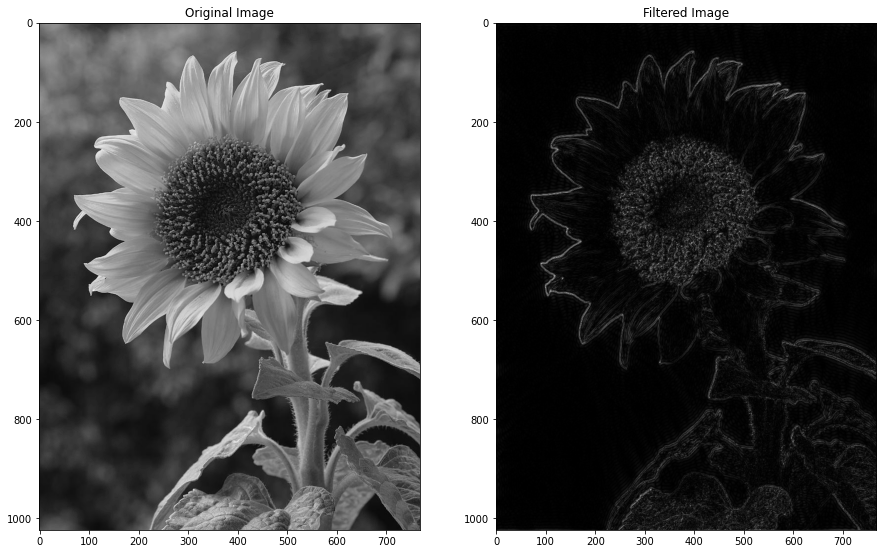

In [150]:
# Inverse shift the zero / low frequency component to the top left and inverse transform back to spatial domain
f_ishift: np.ndarray = np.fft.ifftshift(temp)
spatial_rep: np.ndarray = cv2.idft(f_ishift)
spatial_rep = cv2.magnitude(spatial_rep[:, :, 0], spatial_rep[:, :, 1])
# Plot the original image and high-pass filtered image side by side
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(spatial_rep, cmap='gray')
ax2.set_title('Filtered Image');